In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_profiling 
from pandas_profiling import ProfileReport
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as seabornInstance 
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
dataset = pd.read_csv('salary.csv')
display(dataset)


salary  exprior  yearsworked  yearsrank  market  degree  otherqual  \
0    53000.0        0            0          0    1.17       1          0   
1    58000.0        1            0          0    1.24       1          0   
2    45500.0        0            0          0    1.21       1          0   
3    35782.0        0            2          1    0.99       1          0   
4    34731.0        0            2          2    0.91       1          0   
..       ...      ...          ...        ...     ...     ...        ...   
509  45906.0        6           17         11    0.92       1          0   
510  60402.0        6           19          7    0.86       1          0   
511  53187.0       19            7          6    0.78       1          0   
512  56542.0        8           20         10    0.78       1          0   
513  52662.0       13           25         11    0.78       1          0   

     position  male  Field  yearsabs  
0           1     1      3         0  
1           1     1      2         0  
2           1     1      3         2  
3           1     1      4         1  
4           1     1      4         1  
..        ...   ...    ...       ...  
509         2     0      2        70  
510         3     0      1        72  
511         3     0      4        76  
512         3     0      2        78  
513         3     0      1       112  

[514 rows x 11 columns]

In [3]:
descr = pd.read_csv('Salary_metadata.csv', sep=';')
display(descr)

Variable         Type  \
0        salary   Continuous   
1       exprior   Continuous   
2   yearsworked   Continuous   
3     yearsrank   Continuous   
4        market   Continuous   
5        degree       Binary   
6     otherqual       Binary   
7      position  Categorical   
8          male       Binary   
9         Field  Categorical   
10     yearsabs   Continuous   

                                          Explanation  
0                            Annual salary in dollars  
1   Years of experience prior to working in this f...  
2                          Years worked in this field  
3                       Years worked at current rank   
4   Market value (1 = salary at market value for p...  
5                        Has degree (0 = no, 1 = yes)  
6   Has other post-secondary qualification (0 = no...  
7   Position (1 = Junior Employee, 2 = Manager, 3 ...  
8                                     0 = no, 1 = yes  
9   Field of work (1 = Engineering, 2 = Finance, 3...  
10  Years absent from work (e.g. due to illness / ...

In [4]:
# - Renaming column variable for better understanding and for clarity
# -  Gender -
#dataset.rename(columns={'male': 'gender'},inplace=True)
# - Variables - 
#dataset.replace({'gender':{0:'Female',1:'Male'}}, inplace=True)


In [5]:
ProfileReport(dataset)

In [6]:
dataset = dataset.dropna()
dataset.isnull().sum()

salary         0
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64

On our dataset we had 514 people that where observed with one column containing missing infomation, 386 were Males and 128 were Females


We can use years worked, years rank,position and market as variables to predict salary because there is a positive linear relationship between them when compared to salary

The yearsabs column would need to be transformed because it is not consistant and is not captured correctly. We would need to change the column to days absent or convert the yearabs to days absent because no one can be absent for 60 years at work it does not make any sense

### Features Engineering

In [7]:
dataset.replace({'Field':{1:'Engineering',2:'Finance',3:'Human Resources',4:'Marketing'}}, inplace=True)

c:\users\cna\miniconda\lib\site-packages\pandas\core\generic.py:6666: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


In [8]:
dummies = pd.get_dummies(dataset.Field)
dummies

Engineering  Finance  Human Resources  Marketing
0              0        0                1          0
1              0        1                0          0
2              0        0                1          0
3              0        0                0          1
4              0        0                0          1
..           ...      ...              ...        ...
509            0        1                0          0
510            1        0                0          0
511            0        0                0          1
512            0        1                0          0
513            1        0                0          0

[513 rows x 4 columns]

In [9]:
merged = pd.concat([dummies,dataset],axis=1)
remove = ['Field','Human Resources']
merged = merged[merged.columns.difference(remove)]
merged

Engineering  Finance  Marketing  degree  exprior  male  market  \
0              0        0          0       1        0     1    1.17   
1              0        1          0       1        1     1    1.24   
2              0        0          0       1        0     1    1.21   
3              0        0          1       1        0     1    0.99   
4              0        0          1       1        0     1    0.91   
..           ...      ...        ...     ...      ...   ...     ...   
509            0        1          0       1        6     0    0.92   
510            1        0          0       1        6     0    0.86   
511            0        0          1       1       19     0    0.78   
512            0        1          0       1        8     0    0.78   
513            1        0          0       1       13     0    0.78   

     otherqual  position   salary  yearsabs  yearsrank  yearsworked  
0            0         1  53000.0         0          0            0  
1            0         1  58000.0         0          0            0  
2            0         1  45500.0         2          0            0  
3            0         1  35782.0         1          1            2  
4            0         1  34731.0         1          2            2  
..         ...       ...      ...       ...        ...          ...  
509          0         2  45906.0        70         11           17  
510          0         3  60402.0        72          7           19  
511          0         3  53187.0        76          6            7  
512          0         3  56542.0        78         10           20  
513          0         3  52662.0       112         11           25  

[513 rows x 13 columns]

#### Correlation and Statistical Significance Analysis

###### Hypothesis

Null hypothesis - position,years ranked and yearsworked are not good salary predictors as there is no relationship when campared with salary

Alternative - position,years ranked and yearsworked are good salary predictors as there is a relationship when campared with salary

#### Question 3

In [10]:
# - Pearson correlation coeffificent and the correspnding correlation matrix

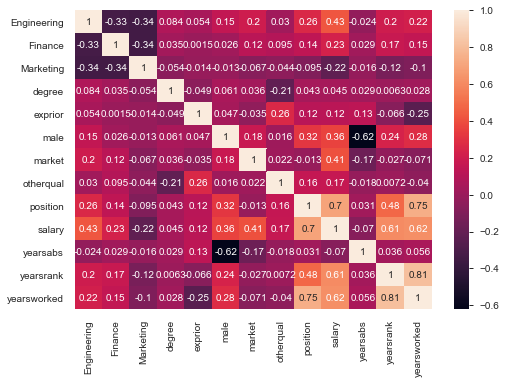

In [11]:
corr  =  merged.corr()
sns.heatmap(corr, annot=True)

The above heatmap shows that position,years ranked and yearsworked are good salary predictors with a strong positive correlation as compared to other variables. Intrestingly yearsabs has a negative correlation while other variables like study fiels also do show positive correlation

#####  P-values related to the Pearson correlation coeffificents

In [12]:
from scipy import stats
# P-Value and varience
print(f'p-values between years-worked and salary: {stats.pearsonr(merged.salary, merged.yearsworked)}')
print(f'p-values between years-rank and salary: {stats.pearsonr(merged.salary, merged.yearsrank)}')
print(f'p-values between postion and salary: {stats.pearsonr(merged.salary, merged.position)}')

p-values between years-worked and salary: (0.6235888657598049, 1.2873351342915672e-56)
p-values between years-rank and salary: (0.6107063176375227, 9.307173080331551e-54)
p-values between postion and salary: (0.7021217379212223, 2.1640014953111997e-77)


With the calculated P-value we can reject the null hypothesis because the variables have a strong correlation and have a higher p-value

###### Multicollinearity

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
merged['salary'] # dependent variable
X = merged.drop(['salary','exprior','otherqual','degree','exprior','male','market','yearsabs'], axis=1)

vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['feature'] = X.columns
display(vif)

VIF Factor      feature
0    2.278273  Engineering
1    2.128060      Finance
2    1.864045    Marketing
3    9.886126     position
4    7.075782    yearsrank
5   14.194886  yearsworked

#### Feature Selection

For feature selection i used the Embedded method. The Embedded method is iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

In [14]:
y = merged['salary']
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 74.583323
Best score using built-in LassoCV: 0.696799


In [15]:
print("Lasso picked  all " + str(sum(coef != 0)) + " and didnt elimenate variable")

Lasso picked  all 6 and didnt elimenate variable


Text(0.5, 1.0, 'Feature importance using Lasso Model')

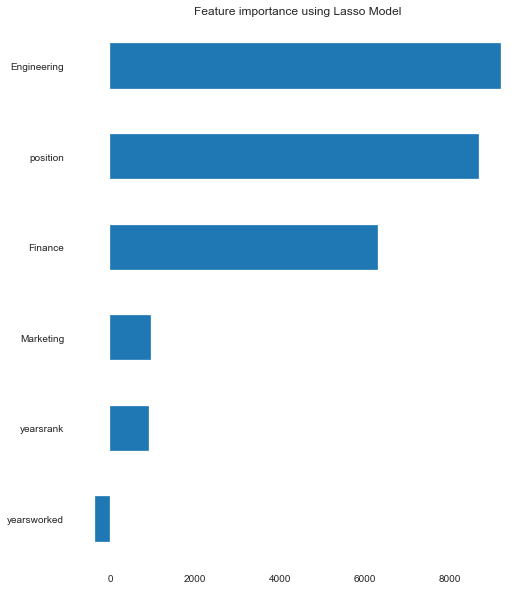

In [16]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Train model:

In [17]:
# -  Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [18]:
X = merged.drop(['salary','exprior','otherqual','degree','exprior','male','market','yearsabs'], axis=1)
y = merged['salary']

In [19]:
from sklearn import datasets, linear_model
model1 = linear_model.LinearRegression()
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

In [20]:
sd_coeff = model1.coef_

display(sd_coeff)

array([10489.22417147,  6628.34792167,  1848.80405488,  8971.81466017,
         836.85324475,  -358.2005073 ])

##### Model Testing

In [35]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df.head(10))

NameError: name 'y_pred' is not defined

In [36]:
print ('Score:', model1.score(X_test, y_test))

Score: -15.528679095848911


## Object-Orientated Programming.

In [37]:
class ErrorCalculator:
    def __init__(self, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
    
    def get_residuals(self):
        return self.y_test - self.y_pred
    
    def get_standardised_residuals(self):
        return self.get_residuals() / self.get_residuals().std()
    
    def get_mse(self):
        return np.square(np.subtract(self.y_test, self.y_pred)).mean()
    
    def get_rmse(self):
        self.get_mse = np.mean( (self.y_pred(y_test_) - y_test_) ** 2 )
        return get_rmse_
    
    def error_summary(self):
        return pd.DataFrame ({'Standardized Residuals Average Mean' : [self.get_standardized_residuals().mean()],
                            'Standardized Residuals Average Min': [self.get_standardized_residuals().min()],
                            'Standadized Residuals Average Max' : [self.get_standardized_residuals().max()],
                            'MSE': [self.get_sme()],
                            'RMSE': [self.get_rmse()]})
    

In [38]:
# - Class Plotterwith Method run_calculations

In [39]:
class Plotter():
    def __init__(self, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
    
    def run_calculations(self):
        return self.y_test - self.y_pred
    
    def plot(self):
        plt.hist(self.y_test - self.y_pred)
        plt.title('Residuals Plot for predictions')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        return plt.show()
# - Child Classes #- Inharitance 

class HistogramPlotter(Plotter):
    def __init__(self, y_test, y_pred):
        super().__init__(y_test, y_pred)
        
    #def HistogramPlotter.plot():

# - Child Classes #- Inharitance 

class ScatterPlotter(Plotter):
    def __init__(self, y_test, y_pred):
        super().__init__(y_test, y_pred)
        
    def plot(self):
        plt.scatter(self.y_test,self.y_pred ,s=100,alpha=0.75,color='red',edgecolor='k')
        plt.title('Predicted Values vs Actual Values',fontsize=14)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True)
        return plt.show


### Section 2

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler().fit(merged) 
rescaled = scaler.transform(merged)
rescaled = pd.DataFrame(rescaled, columns = merged.columns)
rescaled

Engineering   Finance  Marketing    degree   exprior      male    market  \
0      -0.570597 -0.570597  -0.597614  0.190693 -0.612106  0.576600  1.482433   
1      -0.570597  1.752549  -0.597614  0.190693 -0.403322  0.576600  1.951044   
2      -0.570597 -0.570597  -0.597614  0.190693 -0.612106  0.576600  1.750211   
3      -0.570597 -0.570597   1.673320  0.190693 -0.612106  0.576600  0.277434   
4      -0.570597 -0.570597   1.673320  0.190693 -0.612106  0.576600 -0.258121   
..           ...       ...        ...       ...       ...       ...       ...   
508    -0.570597  1.752549  -0.597614  0.190693  0.640595 -1.734305 -0.191176   
509     1.752549 -0.570597  -0.597614  0.190693  0.640595 -1.734305 -0.592843   
510    -0.570597 -0.570597   1.673320  0.190693  3.354780 -1.734305 -1.128398   
511    -0.570597  1.752549  -0.597614  0.190693  1.058162 -1.734305 -1.128398   
512     1.752549 -0.570597  -0.597614  0.190693  2.102079 -1.734305 -1.128398   

     otherqual  position    salary  yearsabs  yearsrank  yearsworked  
0    -0.216654 -1.380170  0.168612 -0.414564  -1.098751    -1.360086  
1    -0.216654 -1.380170  0.563159 -0.414564  -1.098751    -1.360086  
2    -0.216654 -1.380170 -0.423208 -0.296018  -1.098751    -1.360086  
3    -0.216654 -1.380170 -1.190050 -0.355291  -0.942829    -1.148173  
4    -0.216654 -1.380170 -1.272984 -0.355291  -0.786906    -1.148173  
..         ...       ...       ...       ...        ...          ...  
508  -0.216654 -0.159433 -0.391171  3.734546   0.616395     0.441176  
509  -0.216654  1.061303  0.752699  3.853092  -0.007295     0.653089  
510  -0.216654  1.061303  0.183368  4.090184  -0.163217    -0.618390  
511  -0.216654  1.061303  0.448109  4.208730   0.460472     0.759046  
512  -0.216654  1.061303  0.141941  6.224013   0.616395     1.288829  

[513 rows x 13 columns]

### Model1 VS Model2

In [42]:
X1 = rescaled.drop(['salary','exprior','otherqual','degree','exprior','male','market','yearsabs'], axis=1)
y1 = rescaled['salary']


In [43]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

In [44]:
model1 = linear_model.LinearRegression()
model1.fit(X_train1, y_train1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Model 2

In [45]:
data = rescaled.drop('yearsrank', axis = 1)

In [46]:
Y = data['salary']
x = data.drop(['salary','exprior','otherqual','degree','exprior','male','market','yearsabs'], axis=1)

In [47]:
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.2, random_state=0)


In [48]:
model2 = linear_model.LinearRegression()
model2.fit(x_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)